## Player Tracking with Kalman Filter

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

from moviepy.editor import *
from skimage.measure import find_contours
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.pyplot import Rectangle

In [14]:
DATA_DIR = '../data/'
json_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.json')
img_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.png')
IMG_DIR = os.path.join(DATA_DIR, 'volleyball', 'images_subset')
metadata_fpath = os.path.join(DATA_DIR, 'volleyball_bbox_labels.csv')
DETECTIONS_DIR = Path(DATA_DIR, 'volleyball', 'detections')
FIGSIZE=(16,16)
LABEL_NAMES_COCO = ['person', 'sports ball']
LABEL_NAMES = ['red_team', 'blue_team', 'other', 'volleyball']
COLORS = {
    'red': (255,0,0),
    'green': (0,255,0),
    'blue': (0,0,255),
    'white': (255,255,255),
    'black': (0,0,0),
}
LABEL_COLORS = {
    'red_team': COLORS['red'],
    'blue_team': COLORS['blue'],
    'other': COLORS['green']
}

## Helpers

In [86]:
def plot_img(arr, fs=FIGSIZE, cmap='gray', title=None):
    plt.figure(figsize=fs)
    plt.imshow(arr.astype('uint8'), cmap=cmap)
    plt.title(title)
    plt.show()
    
def load_img(fpath):
    return plt.imread(fpath)

def load_cv2_img(fpath, w=None, h=None, colorspace=None):
    img = cv2.imread(fpath)
    if colorspace is not None:
        img = cv2.cvtColor(img, colorspace)
    if None not in [w,h]:
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_CUBIC)
    return img

def threshold_color(img, color, thresh, sigma=1.0):
    """
    color = [b, g, r] or [r,b,g] or [h,s,v]
    thresh = [b,g,r] margin allowed around color (1 per channel)
    """
    if isinstance(thresh, int):
        thresh = [thresh]*3
    thresh = np.array(thresh) * sigma
    min_color = np.array([color[0]-thresh[0], color[1]-thresh[1], 
                          color[2]-thresh[2]])
    max_color = np.array([color[0]+thresh[0], color[1]+thresh[1],
                          color[2]+thresh[2]])
    min_color[min_color < 0] = 0
    max_color[max_color > 255] = 255
    print("Min", min_color)
    print("Max", max_color)
    
    mask = cv2.inRange(img, min_color, max_color)
    result = cv2.bitwise_and(img, img, mask=mask)
    return mask, result

def get_color_of_pixel(fpath, x, y, colorspace='BGR'):
    rgb_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
    hsv_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2HSV)
    
    rgb_colors = rgb_img[y,x,:]
    hsv_colors = hsv_img[y,x,:]
    bgr_colors = np.copy(rgb_colors[::-1])
    print ("BGR:", bgr_colors)
    print ("RGB:", rgb_colors)
    print ("HSV:", hsv_colors)
    
    # Plot to visualize
    img = np.copy(rgb_img)
    img[y-5:y+5:,x-5:x+5,:] = 255
    img[y,x,:] = 0
    
    if colorspace == 'BGR':
        return bgr_colors.tolist()
    if colorspace == 'RGB':
        return rgb_colors.tolist()
    return hsv_colors.tolist()

def get_hsv_value_of_bgr(bgr_color):
    print("BGR", bgr_color)
    bgr_color = np.uint8([[bgr_color]])
    hsv = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2HSV)[0][0]
    print("HSV", hsv)
    return hsv

# Create color histograms representing average values among samples
def get_flattened_channels(imgs):
    chans = np.empty(shape=(1,3))
    for img in imgs:
        h,w,c = img.shape
        reshaped = img.reshape((h*w, c))
        chans = np.concatenate([chans, reshaped], axis=0)
        #print(reshaped.shape, chans.shape)
    return chans

def get_color_hist_dict(imgs, bins, ):
    chans = get_flattened_channels(imgs)
    bgr = ('b','g','r')
    hists = {
        'b':None,
        'g':None,
        'r':None
    }
    for i in range(len(chans[0])):
        hist, bins = np.histogram(chans[:,i], bins, [0,256])
        hists[bgr[i]] = hist
    return hists

def plot_hists_dict(hists):
    for col,hist in hists.items():
        plt.plot(hist, color=col)
    plt.show()
    
def get_color_hist(imgs, bins):
    chans = get_flattened_channels(imgs)
    hists = []
    for i in range(len(chans[0])):
        hist, bins = np.histogram(chans[:,i], bins, [0,256])
        hists.append(hist)
    return hists

def plot_hists(hists, title="None"):
    colors = ('r','g','b')
    for col,hist in zip(colors, hists):
        plt.plot(hist, color=col)
    plt.title(title)    
    plt.show()
    
def plot_bbs_from_rectLabel_annos(json_fpath, img_fpath):
    bb_json = json.load(open(json_fpath, 'r'))
    fig = plt.figure(figsize=FIGSIZE)
    axes = plt.axes([0, 0.03, 1, 0.97])
    
    img = plt.imread(img_fpath)
    imgplot = axes.imshow(img)

    for box in bb_json['objects']:
        label = box['label']
        color = BOX_COLORS[label]
        coords = box['x_y_w_h']
        bb = Rectangle(
            (coords[0],coords[1]), 
            coords[2], coords[3],
            fill=False,
            edgecolor=color,
            linewidth=2)
        axes.add_patch(bb)
        
def get_img_crops_from_rectLabel_bbs(img, json_fpath):
    crops_dict = {}
    bb_json = json.load(open(json_fpath, 'r'))
    for box in bb_json['objects']:
        label = box['label']
        x,y,w,h = box['x_y_w_h']
        crop = img[y:y+h,x:x+w,:]
        if label not in crops_dict:
            crops_dict[label] = []
        crops_dict[label].append(crop)
    return crops_dict

def make_boxes(meta):
    boxes = {}
    for idx,row in meta.iterrows():
        box = json.loads(row.to_json())
        fname = row['filename']
        if fname in boxes:
            boxes[fname].append(box)
        else:
            boxes[fname] = [box]
    return boxes

def median_filter(mask, ksize=3, thresh=25):
    median = cv2.medianBlur(mask, ksize)
    return median

def opening(img, ksize=(3,3)):
    # Erode --> Dilate
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    img = cv2.erode(img, erode_kernel, iterations = 1)
    img = cv2.dilate(img, dilate_kernel, iterations = 1)
    return img

def closing(img, ksize=(3,3)):
    # Dilate --> Erode
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    img = cv2.dilate(img, dilate_kernel, iterations = 1)
    img = cv2.erode(img, erode_kernel, iterations = 1)
    return img

def apply_bg_mask(fpaths, subtractor, limit=100, cleanup=None):
    i = 0
    masks = []
    for fpath in fpaths:
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        fgmask = subtractor.apply(img)
        if cleanup == 'open':
            fgmask = opening(fgmask)
        elif cleanup == 'close':
            fgmask = closing(fgmask)
        elif cleanup == 'median':
            fgmask = median_filter(fgmask)
        fgmask[fgmask >= 2] = 255
        fgmask[fgmask < 2] = 0
        masks.append(fgmask)
        if i > limit:
            break
        i+=1
    return masks

def get_masked_imgs(fpaths, masks):
    imgs = []
    for fpath, mask in zip(fpaths, masks):
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        img[mask == 0] = 255
        imgs.append(img)
    return imgs

def get_img_crop(img, x1, y1, x2, y2):
    if len(img.shape) > 2:
        return img[y1:y2,x1:x2,:]
    return img[y1:y2,x1:x2]

def plot_boxes(img, rects, title="boxes", color=(255,255,255), thick=2):
    for (x1, y1, x2, y2) in rects:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thick)
    plot_img(img, title=title)
    
    import random

def random_colors(N, bright=True):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def create_display_img(image, boxes, masks, class_ids, class_names, scores, ax=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    if ax is None:
        _, ax = plt.subplots(1, figsize=FIGSIZE)

    # Generate random colors
    colors = random_colors(N)
    
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = (0.0, 1.0, 0.40000000000000036)# colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)

        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)

    return ax.imshow(masked_image.astype(np.uint8))

def get_label_hists(label, crops, plot=False, bins=20):
    avg_hist = get_color_hist(crops, bins=bins)
    comb_hist = cv2.calcHist(
        crops, [0, 1, 2], None, [bins, bins, bins], 
        [0, 256, 0, 256, 0, 256])
    avg_norm_hist = cv2.normalize(comb_hist, comb_hist).flatten()
    if plot:
        plot_hists(avg_hist,title=label)
        plt.plot(avg_norm_hist)
        plt.show()
    return avg_hist, avg_norm_hist

def draw_boxes(img, bbs, color=(0,255,0)):
    for (y1, x1, y2, x2) in bbs:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness=2)
    return img

def get_center_court_line_y(x, slope, bias):
    return slope*x + bias

def filter_bbs(bbs, min_y, max_y, margin=0):
    valid_bbs = []
    for bb in bbs:
        valid = True
        y1, x1, y2, x2 = bb
        if y2 > max_y or y2 < min_y:
            valid = False
        w = x2 - x1
        h = y2 - y1
        area = w * h
        if area > 30000 or area < 2000:
            valid = False
        if valid:
            valid_bbs.append(bb)
    return valid_bbs

def classify_teams(bbs, court_details, margin=0):
    red_team = []
    blue_team = []
    referee = []
    for bb in bbs:
        y1, x1, y2, x2 = bb
        avg_x = (x1 + x2) / 2
        center_y = get_center_court_line_y(avg_x, court_details['center_line_slope'], 
                                           court_details['center_line_bias']) + margin
        if y2 <= center_y:
            blue_team.append(bb)
        else:
            red_team.append(bb)
    return red_team,blue_team

def filter_bbs(bbs, min_y, max_y, margin=0):
    valid_bbs = []
    for bb in bbs:
        valid = True
        y1, x1, y2, x2 = bb
        if y2 > max_y or y2 < min_y:
            valid = False
        w = x2 - x1
        h = y2 - y1
        area = w * h
        if area > 30000 or area < 2000:
            valid = False
        if valid:
            valid_bbs.append(bb)
    return valid_bbs

def is_valid_bb(bb, min_y, max_y, margin=0):
    y1, x1, y2, x2 = bb
    if y2 > max_y or y2 < min_y:
        return False
    w = x2 - x1
    h = y2 - y1
    area = w * h
    if area > 30000 or area < 2000:
        return False
    return True

def classify_detection(bb, min_y, max_y, margin=0):
    if not is_valid_bb(bb, min_y, max_y, margin):
        return 'other'
    y1, x1, y2, x2 = bb
    avg_x = (x1 + x2) / 2
    center_y = get_center_court_line_y(avg_x) + margin
    if y2 <= center_y:
        return 'blue_team'
    return 'red_team'

def process_detections(img_fpaths, top_court_y, bottom_court_y, save=False):
    y_feet_offset = 0
    detections = {}
    for img_fpath in img_fpaths:
        det_fpath = Path(DETECTIONS_DIR, Path(img_fpath).name + '.npy')
        img_detections = np.load(det_fpath)[0]
        img_detections['labels'] = []
        img_detections['positions'] = []
        for idx,bb in enumerate(img_detections['rois']):
            y1, x1, y2, x2 = bb
            label = classify_detection(bb, top_court_y, bottom_court_y, margin=5)
            img_detections['labels'].append(label)
            img_detections['positions'].append({
                'bb': [x1,y1,x2,y2],
                'label': label,
                'color': LABEL_COLORS[label],
                'x_feet': (x2+x1)//2,
                'y_feet': y2 + y_feet_offset,
                'x_body': (x2+x1)//2,
                'y_body': (y2+y1)//2,
            })
        detections[img_fpath] = img_detections
        if save:
            img_det_fpath = Path(DETECTIONS_DIR, 
                                 Path(img_fpath).name + 'processed.npy')
            np.save(img_det_fpath, img_detections)
    return detections

def load_raw_detections(img_fpaths):
    dets = {}
    for fpath in img_fpaths:
        det_fpath = Path(DETECTIONS_DIR, Path(fpath).name + '.npy')
        dets[fpath] = np.load(det_fpath)[0]
    return dets

def load_processed_detections(img_fpaths):
    dets = {}
    for fpath in img_fpaths:
        det_fpath = Path(DETECTIONS_DIR, Path(fpath).name + 'processed.npy')
        dict_ = np.load(det_fpath).reshape((1,))[0]
        dets[fpath] = dict_
    return dets

def get_player_bbs(img_det):
    bbs = filter_bbs(img_det['rois'], TOP_COURT_Y, BOTTOM_COURT_Y, margin=3)
    red,blue = classify_teams(bbs, CENTER_COURT_LINE_Y, margin=10)
    return red,blue

def draw_detections(img, detections, plot_all=False):
    bbs = detections['rois']
    labels = detections['labels']
    positions = detections['positions']
    for idx in range(len(bbs)):
        y1, x1, y2, x2 = bbs[idx]
        color = positions[idx]['color']
        if labels[idx] in ['red_team', 'blue_team'] or plot_all:
            cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness=2)
    return img

In [64]:
metadata = pd.read_csv(metadata_fpath)
fnames = metadata['filename']
fpaths = [os.path.join(IMG_DIR, f) for f in fnames]
metadata['fpath'] = fpaths

## Load Floor Map

In [56]:
# Fpaths
court_details_fpath = Path(DATA_DIR, 'volleyball', 'court_dims.npy')
floor_coords_fpath = Path(DATA_DIR, 'volleyball', 'floor_map_coords.npy')
floor_map_fpath = Path(DATA_DIR, 'volleyball', 'floor_map.npy')

court_details = np.load(court_details_fpath).reshape((1,))[0]
img_to_floor_homography = court_details['img_to_floor_homography']
floor_to_img_homography = court_details['floor_to_img_homography']
floor_coords = np.load(floor_coords_fpath).reshape((1,))[0]
floor_map = np.load(floor_map_fpath)
court_details

{'center_line_bias': 536.9865424430642,
 'center_line_slope': 0.011387163561076604,
 'floor_to_img_homography': array([[  1.24767832e+00,  -1.08279859e-01,   1.50497580e+00],
        [  1.99624555e-02,   4.41131423e-02,   1.57047051e+02],
        [  1.16448841e-05,  -1.82433387e-04,   3.78633722e-01]]),
 'img_to_floor_homography': array([[  7.92883181e-01,   7.11948630e-01,  -2.98448595e+02],
        [ -1.00168002e-01,   8.25858524e+00,  -3.42504016e+03],
        [ -7.26481004e-05,   3.95725745e-03,   1.00000000e+00]]),
 'outer_court_bottom_y': 694,
 'outer_court_top_y': 374,
 'y1_int': 536,
 'y2_int': 551}

In [51]:
def plot_court_floor():
    for point in floor_coords['floor_pts'].values():
        pt = point['x'],point['y']
        cv2.circle(floor_map, pt, 1, color=(255,255,255), thickness=5)
    for line in floor_coords['inner_court_lines'].values():
        pt1 = (line['x1'],line['y1'])
        pt2 = (line['x2'],line['y2'])
        cv2.line(floor_map, pt1=pt1, pt2=pt2, 
                 color=(255, 255, 255), thickness=1)
    plot_img(floor_map, fs=(10,10), title="floor")

def map_point(point, H):
    pt = point.copy()
    pt.append(1)
    pt_arr = np.array([pt]).T
    map_pt = H @ pt_arr
    map_pt /= map_pt[2][0]
    map_pt = map_pt.astype(int).squeeze()[:2]
    return map_pt[0],map_pt[1]

In [52]:
# Map Centers
center_left = map_point([floor_coords['floor_pts']['center_left']['x'], 
                        floor_coords['floor_pts']['center_left']['y']], floor_to_img_homography)
center_right = map_point([floor_coords['floor_pts']['center_right']['x'], 
                          floor_coords['floor_pts']['center_right']['y']], floor_to_img_homography)

((89, 538), (1055, 549))

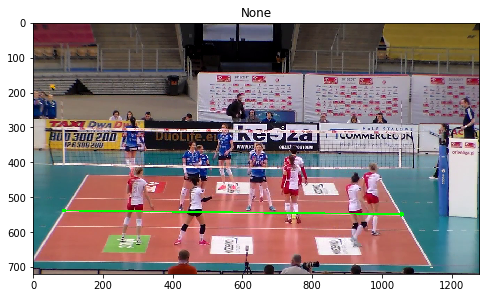

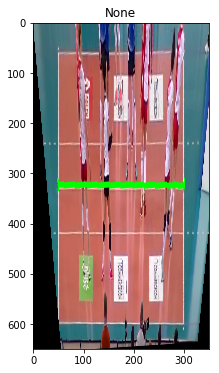

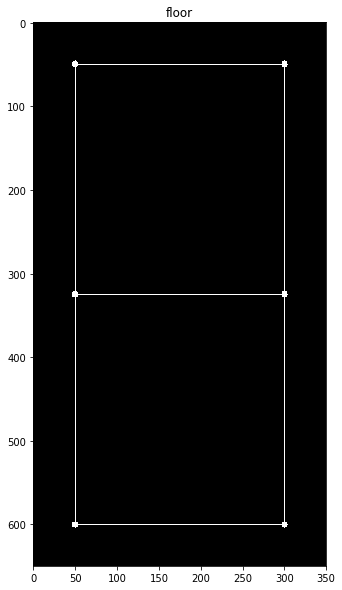

In [53]:
# PLot floor
fpath = metadata['fpath'][0]
img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
cv2.circle(img, (center_left[0], center_left[1]), 1, color=(0,255,0), thickness=10)
cv2.circle(img, (center_right[0], center_right[1]), 1, color=(0,255,0), thickness=10)
cv2.line(img, pt1=center_left, pt2=center_right, color=(0, 255, 0), thickness=3)
plot_img(img, fs=(8,8), title=None)

# Warp Image
im_dst = cv2.warpPerspective(img, img_to_floor_homography, 
                             dsize=(floor_map.shape[1],floor_map.shape[0]))
plot_img(im_dst, fs=(6,6))
plot_court_floor()

## Load Detections

In [60]:
limit = 10
img_fpaths = metadata['fpath'][:limit]
detections = load_processed_detections(img_fpaths)

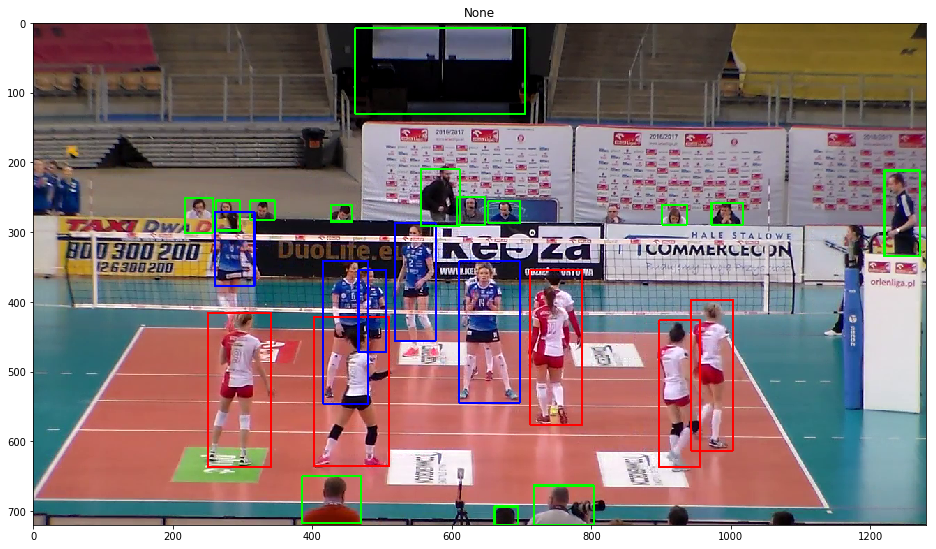

In [62]:
fpath = metadata['fpath'][0]
img = skimage.io.imread(fpath)
img = draw_detections(img, detections[fpath], plot_all=True)
plot_img(img)

## Player Tracking

In [66]:
def get_tracked_imgs(img_fpaths, detections, draw_all=False):
    tracked_imgs = []
    for fpath in img_fpaths:
        img = skimage.io.imread(fpath).astype('uint8')
        det = detections[fpath]
        img = draw_detections(img, det, draw_all)
        tracked_imgs.append(img)
    return tracked_imgs

In [67]:
limit = 10
img_fpaths = metadata['fpath'][:limit]
imgs = get_tracked_imgs(img_fpaths, detections)

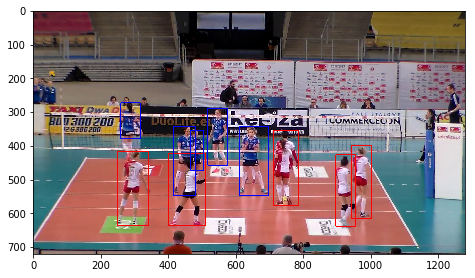

In [68]:
fig = plt.figure()
axes = plt.axes([0, 0.03, 1, 0.97])
img = imgs[0]
imgplot = axes.imshow(img, animated=True)
def init():
    return (imgplot,)

def animate(img):
    imgplot.set_array(img)
    return (imgplot,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=imgs, interval=30, blit=True)

In [69]:
# ~1 minute to generate
HTML(anim.to_html5_video())

## Save Video

* https://youtu.be/UJROEnR2YYI

In [ ]:
clip = ImageSequenceClip(imgs, fps=20)

In [ ]:
outdir = Path(DATA_DIR, 'volleyball', 'player_tracking')
outdir.mkdir(exist_ok=True)
outfpath = str(Path(outdir, 'maskrcnn_w_homography.mp4'))
clip.write_videofile(outfpath)

## Path Tracking

In [90]:
def get_court_position(img_fpaths, detections, court_details, y_feet_offset=-5):
    positions = {}
    for img_fpath in img_fpaths:
        det = detections[img_fpath]
        img_positions = {
            'bbs':[],
            'img_fpath': None,
            'det_fpath': None,
            'detections': None
        }
        img = skimage.io.imread(img_fpath)
        bbs = filter_bbs(det['rois'], court_details['outer_court_top_y'], 
                         court_details['outer_court_bottom_y'], margin=3)
        red,blue = classify_teams(bbs, court_details, margin=5)
        for (y1, x1, y2, x2) in red:
            img_positions['bbs'].append({
                'bb': [x1,y1,x2,y2],
                'team': 'red',
                'color': COLORS['red'],
                'x_feet': (x2+x1)//2,
                'y_feet': y2 + y_feet_offset,
                'x_body': (x2+x1)//2,
                'y_body': (y2+y1)//2,
            })
        for (y1, x1, y2, x2) in blue:
            img_positions['bbs'].append({
                'bb': [x1,y1,x2,y2],
                'team': 'blue',
                'color': COLORS['blue'],
                'x_feet': (x2+x1)//2,
                'y_feet': y2 + y_feet_offset,
                'x_body': (x2+x1)//2,
                'y_body': (y2+y1)//2,
            })
        img_positions['img_fpath'] = img_fpath
        positions[img_fpath] = img_positions
    return positions

In [91]:
court_details

{'center_line_bias': 536.9865424430642,
 'center_line_slope': 0.011387163561076604,
 'floor_to_img_homography': array([[  1.24767832e+00,  -1.08279859e-01,   1.50497580e+00],
        [  1.99624555e-02,   4.41131423e-02,   1.57047051e+02],
        [  1.16448841e-05,  -1.82433387e-04,   3.78633722e-01]]),
 'img_to_floor_homography': array([[  7.92883181e-01,   7.11948630e-01,  -2.98448595e+02],
        [ -1.00168002e-01,   8.25858524e+00,  -3.42504016e+03],
        [ -7.26481004e-05,   3.95725745e-03,   1.00000000e+00]]),
 'outer_court_bottom_y': 694,
 'outer_court_top_y': 374,
 'y1_int': 536,
 'y2_int': 551}

In [92]:
court_positions = get_court_position(
    metadata['fpath'][:limit], detections, court_details, y_feet_offset=0)

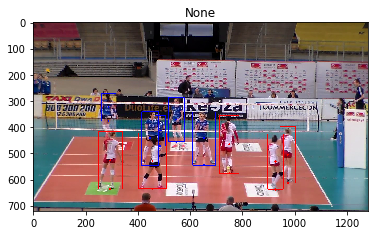

In [93]:
def draw_court_position_img(position):
    img = skimage.io.imread(position['img_fpath']).astype('uint8')
    bbs = position['bbs']
    for bb in bbs:
        x1,y1,x2,y2 = bb['bb']
        cv2.rectangle(img, (x1, y1), (x2, y2), bb['color'], thickness=2)
        feet_pt = bb['x_feet'],bb['y_feet']
        body_pt = bb['x_body'],bb['y_body']
        cv2.circle(img, feet_pt, 1, color=bb['color'], thickness=5)
        cv2.circle(img, body_pt, 1, color=bb['color'], thickness=5)
    return img

fpath = metadata['fpath'][0]
img = draw_court_position_img(court_positions[fpath])
plot_img(img, fs=(6,6))

In [94]:
def get_floor_map():
    floor_map = np.load(floor_map_fpath)
    floor_map = np.repeat(np.expand_dims(floor_map, axis=2), 3, axis=2)
    floor_coords = np.load(floor_coords_fpath).reshape((1,))[0]

    TL = floor_coords['floor_pts']['top_left']
    TR = floor_coords['floor_pts']['top_right']
    BL = floor_coords['floor_pts']['bottom_left']
    BR = floor_coords['floor_pts']['bottom_right']
    floor_map[TL['y']:BL['y'],TL['x']:TR['x'],:] = 255
    floor_map[:,:,:] = 255
    
    for point in floor_coords['floor_pts'].values():
        pt = point['x'],point['y']
        cv2.circle(floor_map, pt, 1, color=(0,255,0), thickness=5)
    for line in floor_coords['inner_court_lines'].values():
        pt1 = (line['x1'],line['y1'])
        pt2 = (line['x2'],line['y2'])
        cv2.line(floor_map, pt1=pt1, pt2=pt2, 
                 color=(0, 255, 0), thickness=2)
    return floor_map.astype('uint8')

def draw_floor_position(position, floor_map, H):
    floor_map = floor_map.copy().astype('uint8')
    bbs = position['bbs']
    for bb in bbs:
        x1,y1,x2,y2 = bb['bb']
        feet_pt = [bb['x_feet'],bb['y_feet']]
        floor_pt = map_point(feet_pt, H)
        cv2.circle(floor_map, floor_pt, 1, color=bb['color'], thickness=5)
    return floor_map.transpose(1,0,2)

../data/volleyball/images_subset/volleyball_frame_00665.png


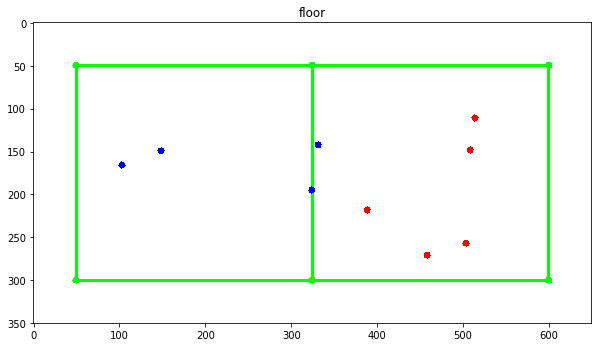

In [96]:
fpath = metadata['fpath'][0]
print(fpath)
position = court_positions[fpath]
floor_map = get_floor_map()
#plot_img(floor_map.transpose(1,0,2), fs=(10,10))
position_map = draw_floor_position(position, floor_map, img_to_floor_homography)
plot_img(position_map, fs=(10,10), title="floor")

In [98]:
floor_map_frames = []
for fpath in metadata['fpath'][:limit]:
    position = court_positions[fpath]
    position_map = draw_floor_position(position, floor_map, img_to_floor_homography)
    floor_map_frames.append(position_map)

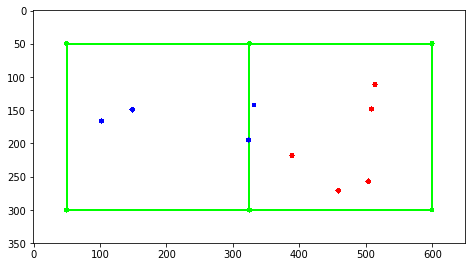

In [99]:
imgs = floor_map_frames
fig = plt.figure()
axes = plt.axes([0, 0.03, 1, 0.97])
img = imgs[0]
imgplot = axes.imshow(img, animated=True)
def init():
    return (imgplot,)

def animate(img):
    imgplot.set_array(img)
    return (imgplot,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=imgs, interval=20, blit=False)

In [100]:
# ~1 minute to generate
HTML(anim.to_html5_video())

## Save Floor Map Video

* https://www.youtube.com/watch?v=foK2x_MQUE4
* http://zulko.github.io/moviepy/getting_started/videoclips.html

In [101]:
clip = ImageSequenceClip(floor_map_frames, fps=40)
outdir = Path(DATA_DIR, 'volleyball', 'player_tracking')
outdir.mkdir(exist_ok=True)
outfpath = str(Path(outdir, 'player_tracking_kalman_filter_floor_map.mp4'))
clip.write_videofile(outfpath)

[MoviePy] >>>> Building video ../data/volleyball/player_tracking/player_tracking_kalman_filter_floor_map.mp4
[MoviePy] Writing video ../data/volleyball/player_tracking/player_tracking_kalman_filter_floor_map.mp4


100%|██████████| 10/10 [00:00<00:00, 163.90it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ../data/volleyball/player_tracking/player_tracking_kalman_filter_floor_map.mp4 



## Links

![HEY](https://github.com/srianant/kalman_filter_multi_object_tracking/blob/master/images/KF_arch.png?raw=true)

Papers:
* http://vc.cs.nthu.edu.tw/home/paper/codfiles/wyyang/201505280559/06935235.pdf
* https://arxiv.org/pdf/1608.06148.pdf
* https://pdfs.semanticscholar.org/9336/9053da157dacff28d6205c7c6f7fa4b9ddf0.pdf
* https://pdfs.semanticscholar.org/616b/7093cfe6ec679f25d63f62c16e937227258f.pdf
* http://faculty.ucmerced.edu/mhyang/papers/cviu17_MOT.pdf
* https://www.ethz.ch/content/dam/ethz/special-interest/baug/igp/photogrammetry-remote-sensing-dam/documents/pdf/cvpr2012-anton.pdf

Tutorials:
* https://www.mathworks.com/help/vision/examples/using-kalman-filter-for-object-tracking.html
* https://www.mathworks.com//help/vision/examples/motion-based-multiple-object-tracking.html
* http://studentdavestutorials.weebly.com/multi-bugobject-tracking.html
* https://www.myzhar.com/blog/tutorials/tutorial-opencv-ball-tracker-using-kalman-filter/
* https://www.myzhar.com/blog/tutorials/tutorial-opencv-ball-tracker-using-kalman-filter/

Assigning Tracks
* https://stackoverflow.com/questions/26363257/tracking-multiple-moving-objects-with-kalmanfilter-in-opencv-c-how-to-assign (BB IoU)
* http://www.hungarianalgorithm.com/examplehungarianalgorithm.php
* https://www.topcoder.com/community/data-science/data-science-tutorials/assignment-problem-and-hungarian-algorithm/

Theory
* https://www.youtube.com/watch?v=aUkBa1zMKv4
* http://bilgin.esme.org/BitsAndBytes/KalmanFilterforDummies

Repos
* https://github.com/srianant/kalman_filter_multi_object_tracking
* https://github.com/Smorodov/Multitarget-tracker
* https://github.com/Myzhar/simple-opencv-kalman-tracker
* https://github.com/abewley/sort
* https://github.com/ZidanMusk/experimenting-with-sort